# Chapter 6
## Time Series Analysis

In [1]:
#import packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt 

import datetime as dt
import os

In [2]:
%store -r c_co_in
%store -r c_co_out

## Distributions in time

### Intraday

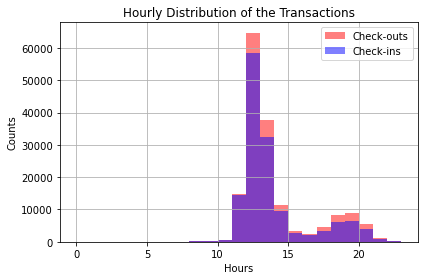

In [3]:
#plot hour distribution for check-ins and outs
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
c_co_out['OwnerTill'].dt.hour.hist(bins=23,alpha = 0.5, color='red', label='Check-outs')
c_co_in['OwnerSince'].dt.hour.hist(bins=23,alpha = 0.5, color='blue', label='Check-ins')
plt.legend()
plt.title('Hourly Distribution of the Transactions')
plt.xlabel('Hours')
plt.ylabel('Counts')
plt.show()


### Days of the Week

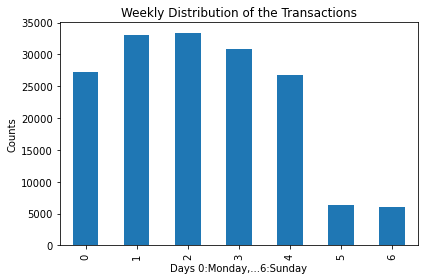

In [4]:
c_co_out['OwnerTill'].dt.weekday.value_counts().sort_index().plot.bar()
plt.title('Weekly Distribution of the Transactions')
plt.xlabel('Days 0:Monday,...6:Sunday')
plt.ylabel('Counts')
plt.show()

## Daily transactions

In [5]:
#get the total check-outs in a day
ops=c_co_out.groupby(c_co_out['OwnerSince'].dt.date).size().to_frame('count')
print(ops.shape)

(837, 1)


In [6]:
# create a bin including empty days between the range of earliest and latest day that a transaction took place
bins=pd.date_range(start=pd.to_datetime(ops.index).min(), end=pd.to_datetime(ops.index).max())
bins=pd.to_datetime(bins)
bins=pd.Series(bins).dt.date
bins=pd.DataFrame(bins, columns=['date'])


# add this bin as an index into df with merge operation
# now, we have all days in the df
ops['date']=pd.to_datetime(ops.index)
ops['date']=ops['date'].dt.date
ops.index=ops['date']

ops=pd.merge(bins,ops, how='left', left_on=bins['date'], \
                 right_index=True).fillna(0).drop(['date_y'], axis=1).rename(columns={'date_x':'date'}).set_index('date')
print(ops.shape)

(894, 1)


## Corona Cases & Checkout Correlation

### Corona Data
https://github.com/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland 
<br> Same data can be seen on https://experience.arcgis.com/experience/478220a4c454480e823b17327b2bf1d4 
<br> filter data with NRW/Köln and look at the graph of Covid-19-Fälle/Tag nach Meldedatum with Zuvorgemeldet filter option. 

In [7]:
df=pd.read_csv('Aktuell_Deutschland_SarsCov2_Infektionen.csv')
df['Meldedatum']= pd.to_datetime(df['Meldedatum'])
df['Refdatum']= pd.to_datetime(df['Refdatum'])

cdf=df[(df['IdLandkreis']==5315)].groupby(df['Meldedatum'].dt.date)['AnzahlFall'].sum().to_frame('corona')

# join with ops transactional data
ops=ops.join(cdf, how='left')#.drop('key_0', axis=1)

ops.tail(100).head()

count  corona
date                     
2021-11-25  544.0   322.0
2021-11-26  406.0   716.0
2021-11-27   88.0   623.0
2021-11-28   68.0   685.0
2021-11-29  556.0   784.0

In [8]:
# plot 7_day_incidence 
for i,row in ops.iterrows():
    ops.loc[i,'7_day']=ops[:i].tail(7)['corona'].mean()

ops.tail(2)

count  corona        7_day
date                                  
2022-03-03  244.0  6851.0  2724.714286
2022-03-04   78.0  4985.0  3173.000000

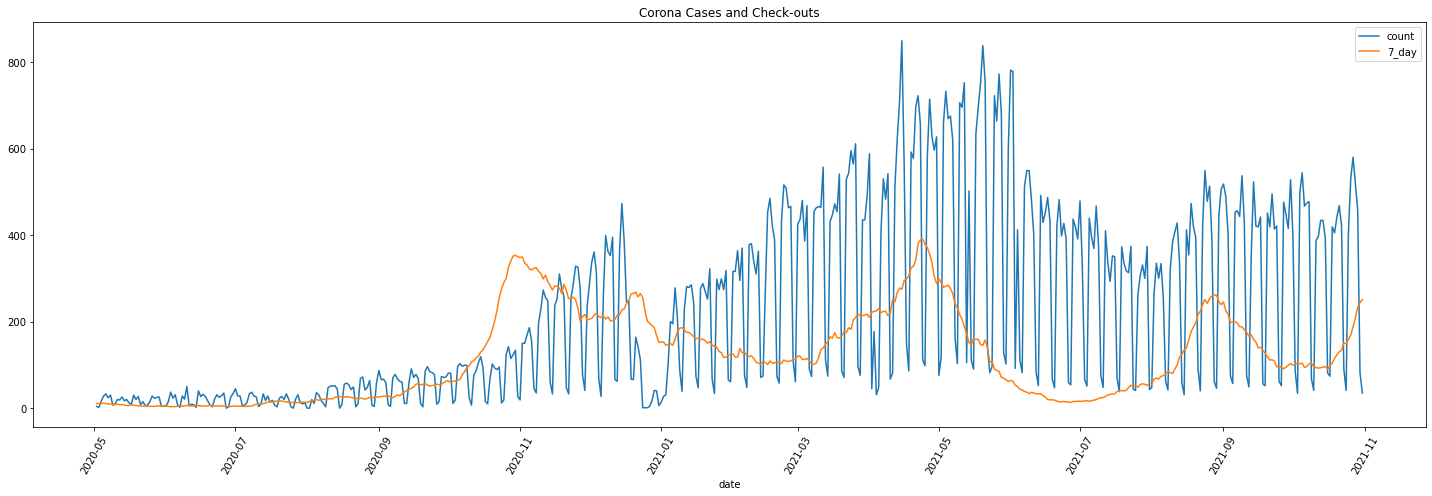

In [9]:
# Since, by autumn 2021, the politicians do not react harshly anymore in terms of counter-restrictions,
# I decided to take into account data up to this date. 
start_date=dt.datetime(2020, 5, 1).date()
end_date=dt.datetime(2021, 11, 1).date()

ops[(ops.index<end_date) &(ops.index>start_date) ][['count','7_day']].plot(figsize=(20,7) )
plt.xticks(rotation=60)
plt.title('Corona Cases and Check-outs')
plt.show()

In [10]:
ops['7_day_r']=ops[(ops.index>start_date) & (ops.index<end_date)]['7_day']
ops.loc[(ops.index<start_date) | (ops.index>end_date), '7_day_r']=None # remove the cases after 31st Oct 2021

### Lockdown dates
https://www.wiwo.de/politik/deutschland/corona-lockdown-so-ist-der-zweite-lockdown-in-deutschland-verlaufen/27076474.html <br>
https://www.wiwo.de/politik/deutschland/corona-wie-verlief-der-erste-lockdown-in-deutschland/26853384.html
<br>
Bundesweit 22 March 2020 - 15 June 2020 <br>

Bundesweit Lockdown:  02 Nov 2020 - 31 May  2021 (7 Monate) <br>

After 1.Oct 2021 Restaurants are fully opened. <br>

https://www.ndr.de/nachrichten/info/Corona-Chronologie-Die-Ereignisse-im-Norden,coronachronologieindex100.html <br>
https://www.ndr.de/nachrichten/info/Chronologie-zur-Corona-Krise-in-Norddeutschland,coronachronologie114.html <br>
https://www.ndr.de/nachrichten/info/Chronologie-zur-Corona-Krise-in-Norddeutschland,coronachronologie116.html <br>

https://www.mdr.de/nachrichten/jahresrueckblick/corona-chronik-chronologie-coronavirus-102.html#sprung2 <br>
 

 
13 March- 19 April 2020 is the first Lockdown. Almost every store was closed. <br> 
https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_Nordrhein-Westfalen#M%C3%A4rz_2020 <br>
https://www1.wdr.de/nachrichten/themen/coronavirus/ticker-archiv-corona-virus-nrw-mai-100.html <br>
 


In [11]:
changepoints = [#'2020-03-13', # first hard lockdown
                #'2020-04-19', # partial relaxation
                '2020-11-02', # second lockdown
                '2020-12-21',# weichnachten begins
                '2021-01-06', # weichnacten ends
                '2021-06-02', # easing the lockdown 
                '2021-07-05', # sommerfeirien
                '2021-08-23'  # school start in NRW
              ]

#### 2022 school holiday in NRW
https://www.schulferien.org/deutschland/ferien/nordrhein-westfalen/ <br>
https://www.kalenderpedia.de/ferien/ferien-nrw-2022.html <br>

Weihnachtsferien NRW 2021/22	24.12.21 - 8.1.22
Winterferien	Winterferien NRW 2022	-
Osterferien	Osterferien NRW 2022	11.4. - 23.4.22
Pfingstferien	Pfingstferien* NRW 2022	-
Sommerferien	Sommerferien NRW 2022	27.6. - 9.8.22
Herbstferien	Herbstferien NRW 2022	4.10. - 15.10.22
Weihnachtsferien	Weihnachtsferien NRW 2022/23	23.12.22 - 6.1.23


### School days in 2021 in NRW
https://www.ferienkalender.com/ferien_deutschland/Nordrhein-Westfalen/2021-ferien-nordrhein-westfalen.htm

Winterferien	-
Osterferien / Frühjahrsferien	29.03. - 10.04.
Pfingstferien	25.05.
Sommerferien	05.07. - 17.08.
Herbstferien	11.10. - 23.10.
Weihnachtsferien	24.12. - 08.01.


https://www.ferienkalender.com/ferien_deutschland/Nordrhein-Westfalen/2020-ferien-nordrhein-westfalen.htm


### Ferien 2020 im deutschen Bundesland Nordrhein-Westfalen:

Winterferien	-
Osterferien / Frühjahrsferien	06.04. - 18.04.
Pfingstferien	02.06.
Sommerferien	29.06. - 11.08.
Herbstferien	12.10. - 24.10.
Weihnachtsferien	21.12. - 06.01.

### Ferien 2019
https://www.kalenderpedia.de/ferien/ferien-nrw-2019.html
<br>
Herbstferien NRW 2019	14.10. - 26.10.19
Weihnachtsferien NRW 2019/20	23.12.19 - 6.1.20


In [12]:
import holidays
nrw_holidays = holidays.country_holidays('DE', subdiv='NW')
nrw_holidays

d_list=pd.date_range(start='2019-08-01', end='2022-12-31')

#[d for d in d_list if d in nrw_holidays]

holidays=pd.DataFrame({'holiday':'official_holiday', 'ds':[d for d in d_list if d in nrw_holidays]})

#holidays.tail()

In [13]:
weekends = pd.DataFrame({'holiday': 'weekend','ds': pd.date_range(start='2019-08-01', end='2022-04-23')}) 
weekends=weekends[weekends['ds'].dt.weekday.isin([5,6])]

In [14]:
#2021 School holidays
ostern_2022 = pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2022-04-11', end='2022-04-23')}) 
ostern_2021 = pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2021-03-29', end='2021-04-10')})                            
ostern_2020 = pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2020-04-06', end='2020-04-18')})

pfingstferien_2021 = pd.DataFrame({'holiday': 'school_holiday','ds': pd.to_datetime(['2021-05-25'])})
pfingstferien_2020 = pd.DataFrame({'holiday': 'school_holiday','ds': pd.to_datetime(['2021-06-02'])})
                                   
sommerferien_2022= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2022-06-27', end='2022-08-09')})                          
sommerferien_2021= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2021-07-05', end='2021-08-17')})   
sommerferien_2020= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2020-06-29', end='2020-08-11')})  
 
herbstferien_2022= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2022-10-10', end='2022-10-15')}) 
herbstferien_2021= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2021-10-11', end='2021-10-23')}) 
herbstferien_2020= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2020-10-12', end='2020-10-24')})  
herbstferien_2019= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2019-10-14', end='2019-10-26')})  


weihnachtsferien_2022= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2022-12-23', end='2023-01-06')})                                
weihnachtsferien_2021= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2021-12-24', end='2022-01-08')})
weihnachtsferien_2020= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2020-12-21', end='2021-01-06')})
weihnachtsferien_2019= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2019-12-23', end='2020-01-06')})


school_holidays = pd.concat([ostern_2022,ostern_2021,ostern_2020,\
                             pfingstferien_2021, pfingstferien_2020,\
                            sommerferien_2022,sommerferien_2021,sommerferien_2020,\
                             herbstferien_2022, herbstferien_2021,herbstferien_2020,herbstferien_2019,\
                            weihnachtsferien_2022,weihnachtsferien_2021,weihnachtsferien_2020,weihnachtsferien_2019,\
                             ])
#school_holidays.tail()

In [15]:
school_holidays=school_holidays[~school_holidays['ds'].isin(holidays['ds'])]
#school_holidays.shape

In [16]:
school_holidays=school_holidays[school_holidays['ds'].dt.weekday.isin([0,1,2,3,4])]
#school_holidays.shape

In [17]:
weihnachten_business_2021=pd.DataFrame({'holiday': 'christmas_break','ds':pd.date_range(start='2021/12/23', periods=9)})
weihnachten_business_2020=pd.DataFrame({'holiday': 'christmas_break','ds':pd.date_range(start='2020/12/23', periods=9)})
weihnachten_business_2019=pd.DataFrame({'holiday': 'christmas_break', 'ds':pd.date_range(start='2019/12/23', periods=9)})

christmas = pd.concat([weihnachten_business_2021,weihnachten_business_2020,weihnachten_business_2019 ])
christmas=christmas[christmas['ds'].dt.weekday.isin([0,1,2,3,4])]

In [18]:
#christmas

In [19]:
# counts per day in Cologne
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
#c_co_out['OwnerSince']=c_co_out['OwnerSince'].apply(lambda x: x.replace(tzinfo=None))# for FB Prophet
ops_out=c_co_out.groupby(by=c_co_out['OwnerSince'].dt.date).size().to_frame('count')
ops_out['7_day']=ops['7_day']

In [20]:
break_time=dt.datetime(2021, 10, 1).date()

ops_out.loc[(ops_out.index<start_date), '7_day']=None # initial part of corona data. 
ops_out.loc[(ops_out.index>break_time), '7_day']=ops_out[ops_out.index<=break_time]['7_day'].mean() # assign mean of corona after 1.10.2021 because it is not relevant anymore. 
ops_out.tail()

count       7_day
OwnerSince                   
2022-02-28    123  119.516055
2022-03-01    417  119.516055
2022-03-02    377  119.516055
2022-03-03    244  119.516055
2022-03-04     78  119.516055

In [21]:
# second approach

for i, row in ops_out.iterrows():
    #print(row['ds'].weekday())
    if int(i.weekday()) in [5,6] or i in nrw_holidays:
    #if row['date'] in nrw_holidays:
        ops_out.loc[i, 'is_holiday']=1
    else: 
        ops_out.loc[i, 'is_holiday']=0

In [22]:
#ops_out.tail(10)

In [23]:
#import pandas as pd
#import numpy as np

from fbprophet import Prophet
import json
from fbprophet.serialize import model_to_json, model_from_json
from datetime import timedelta
import plotly.offline as py
py.init_notebook_mode()

In [24]:

from fbprophet.plot import (
    plot_plotly,
    plot_components_plotly,
    plot_forecast_component_plotly,
    plot_seasonality_plotly,
    add_changepoints_to_plot
)

In [25]:
ops_out['y']= ops_out['count']

ops_out['ds']= pd.Series()
ops_out['ds']=pd.to_datetime(ops_out.index)
ops_out['date']=ops_out.index
#ops_out.loc[ops_out['ds'].isin(christmas['ds']), 'y']=None # remove christmas period

/var/folders/bs/8_rscwxd25z1bcq4d89vsz380000gn/T/ipykernel_47980/2031727652.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [26]:
break_day=dt.datetime(2021, 10, 1).date()
idx=ops_out[ops_out.index>=break_day].index
ops_out.loc[idx,'7_day']=ops_out['7_day'].mean()
ops_out.tail(10)

count       7_day  is_holiday    y         ds        date
OwnerSince                                                           
2022-02-23    567  119.516055         0.0  567 2022-02-23  2022-02-23
2022-02-24    207  119.516055         0.0  207 2022-02-24  2022-02-24
2022-02-25    344  119.516055         0.0  344 2022-02-25  2022-02-25
2022-02-26     39  119.516055         1.0   39 2022-02-26  2022-02-26
2022-02-27     35  119.516055         1.0   35 2022-02-27  2022-02-27
2022-02-28    123  119.516055         0.0  123 2022-02-28  2022-02-28
2022-03-01    417  119.516055         0.0  417 2022-03-01  2022-03-01
2022-03-02    377  119.516055         0.0  377 2022-03-02  2022-03-02
2022-03-03    244  119.516055         0.0  244 2022-03-03  2022-03-03
2022-03-04     78  119.516055         0.0   78 2022-03-04  2022-03-04

In [27]:
begin_date=dt.datetime(2020, 5, 2).date()
break_time=dt.datetime(2021, 11, 1).date()
end_date=dt.datetime(2022, 3, 1).date()


# create train & test dataset: 

#ops_out['cap']=500 # for logistic regression
#ops_out['floor']=0
train = ops_out[(ops_out.index<break_time) & (ops_out.index>=begin_date) ]
future=ops_out[(ops_out.index>=break_time) & (ops_out.index<end_date)]
#train.head(99).tail(19)

In [28]:
# from https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [29]:
    
# to surpress the print outs
with suppress_stdout_stderr():
    # define the model
    model = Prophet(#growth='flat', \
                    seasonality_mode='multiplicative',\
                    holidays=christmas,holidays_prior_scale=10,
                    changepoints=changepoints,
                    changepoint_prior_scale=0.5,
                    changepoint_range=0.95,
                    yearly_seasonality=False,
                    daily_seasonality=False, \
                    weekly_seasonality=False)#.add_country_holidays(country_name='DE')
    model.add_seasonality(name='weekly', period=7, fourier_order=10, prior_scale=4,mode='multiplicative')
    model.add_seasonality(name='yearly', period=365, fourier_order=5, prior_scale=4,mode='additive')
    #model.add_regressor(name='is_holiday', prior_scale=10, standardize='auto', mode='multiplicative')# 'additive'
    model.add_regressor(name='7_day', prior_scale=10, standardize='auto', mode='multiplicative')# add corona 7_day as a regressor 
    # fit the model
    model.fit(train)



/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kultiginbozdemir/opt/anaconda

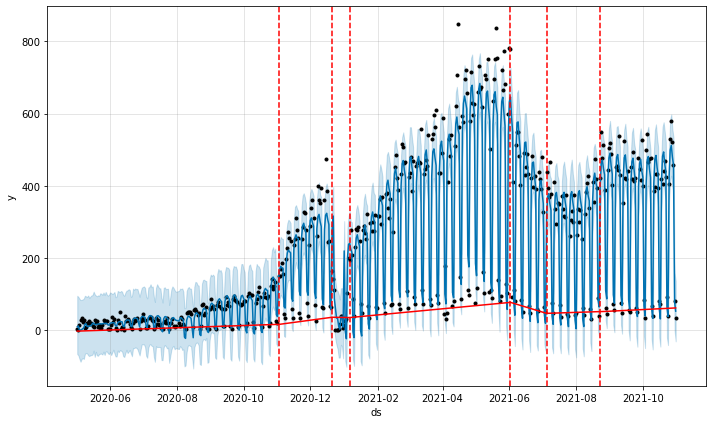

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/plot.py:422: 

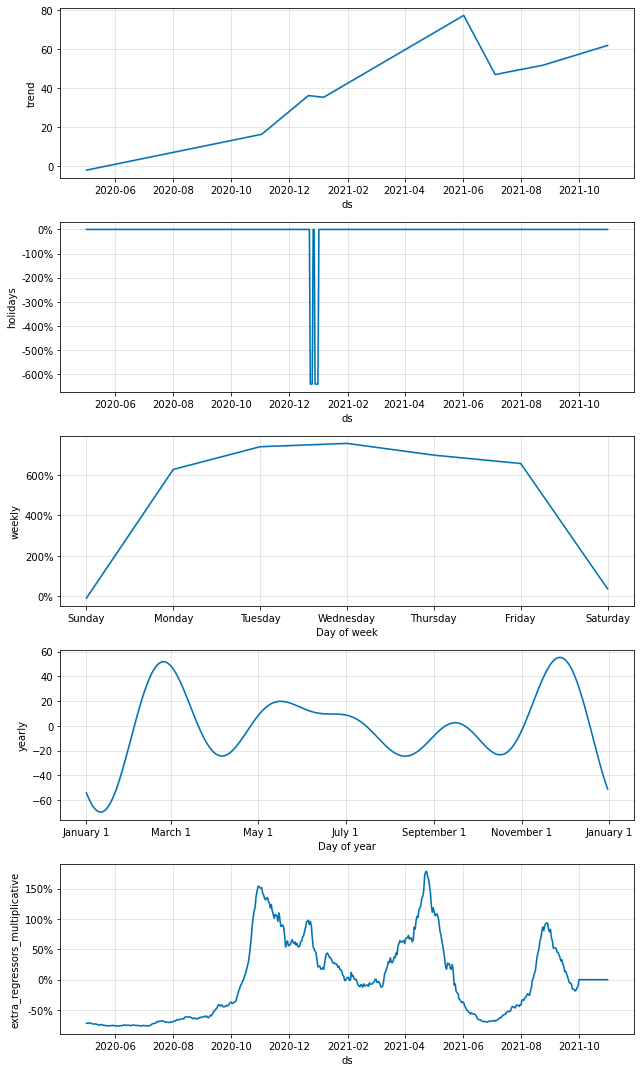

In [30]:

# use the model to make a forecast
forecast = model.predict()
fig=model.plot(forecast)
add_changepoints_to_plot(fig.gca(),model, forecast)
plt.show()
fig2=model.plot_components(forecast)
plt.show()

In [31]:
from fbprophet.utilities import regressor_coefficients
regressor_coefficients(model)

regressor  regressor_mode      center  coef_lower      coef  coef_upper
0     7_day  multiplicative  119.751316    0.006604  0.006604    0.006604

Now, we get yearly seasonal coefficients. We can use them as a regressor in the new model. 
The model is identical but yearly seasonality is replaced with those new coefficients in a regressor. 

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kultiginbozdemir/opt/anaconda

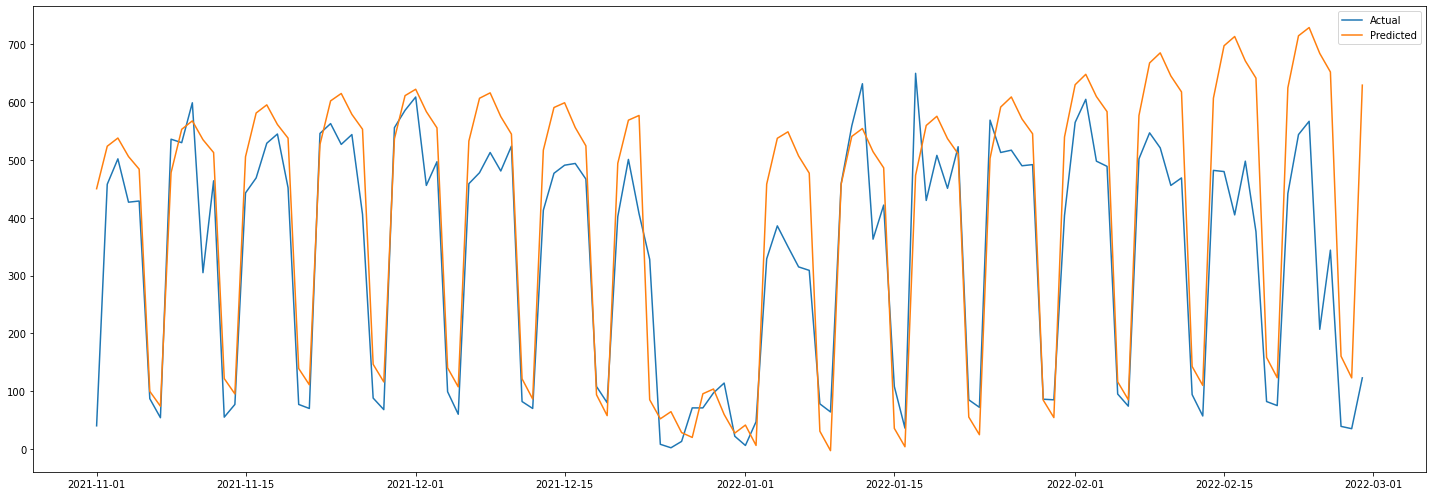

In [32]:

# use the model to make a forecast
forecast = model.predict(future)
# calculate MAE between expected and predicted values for december
y_true = future['y']
y_pred = forecast['yhat']

#mae = mean_absolute_error(y_true, y_pred)
#print('MAE: %.3f' % mae)
# plot expected vs actual
plt.figure(figsize=(20, 7))
plt.plot(future.index,future['y'], label='Actual')
plt.plot(forecast.ds,forecast['yhat'], label='Predicted')
plt.legend()
plt.show()

In [33]:
forecast[['ds','yhat']].merge(future[['y','ds']], how='left', left_on='ds', right_on='ds').tail(10)


ds        yhat    y
110 2022-02-19  158.241820   82
111 2022-02-20  123.143737   75
112 2022-02-21  624.937334  442
113 2022-02-22  714.956173  544
114 2022-02-23  729.208416  567
115 2022-02-24  684.419532  207
116 2022-02-25  652.324996  344
117 2022-02-26  160.435932   39
118 2022-02-27  122.971551   35
119 2022-02-28  629.582141  123

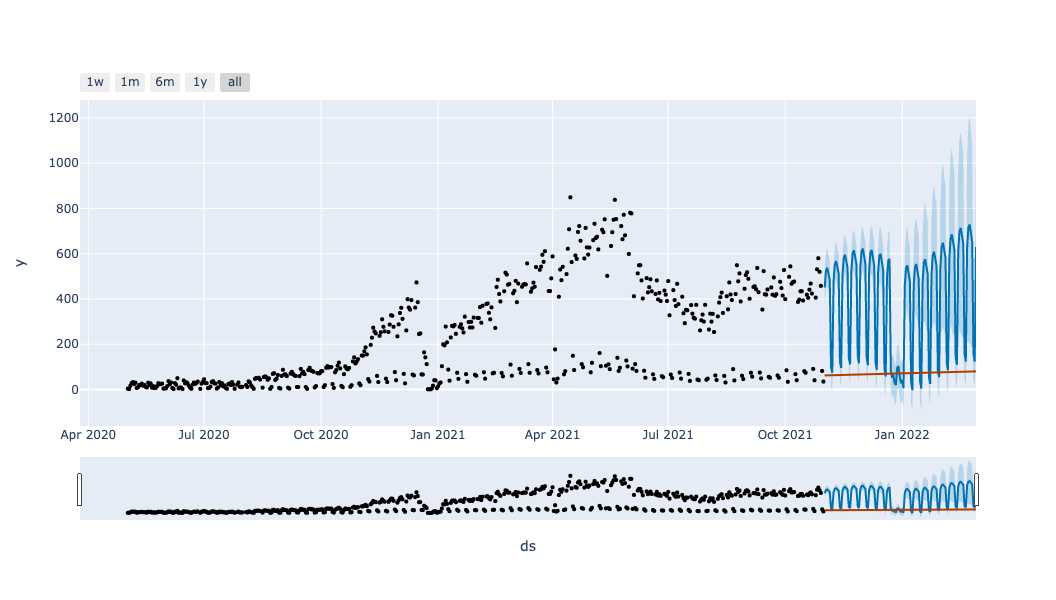

In [34]:
fig = plot_plotly(model, forecast, trend=True)
py.iplot(fig)

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kultiginbozdemir/opt/anaconda

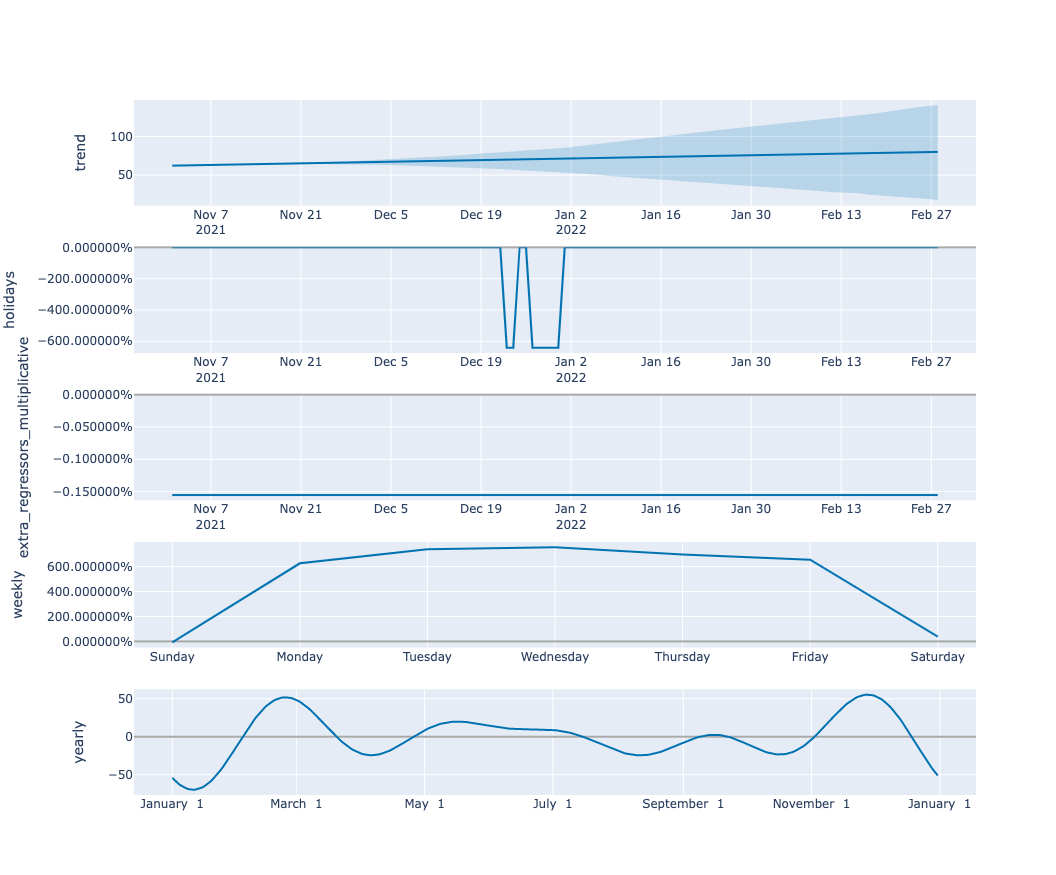

In [35]:
fig = plot_components_plotly(model, forecast , figsize=(800, 175))
py.iplot(fig)